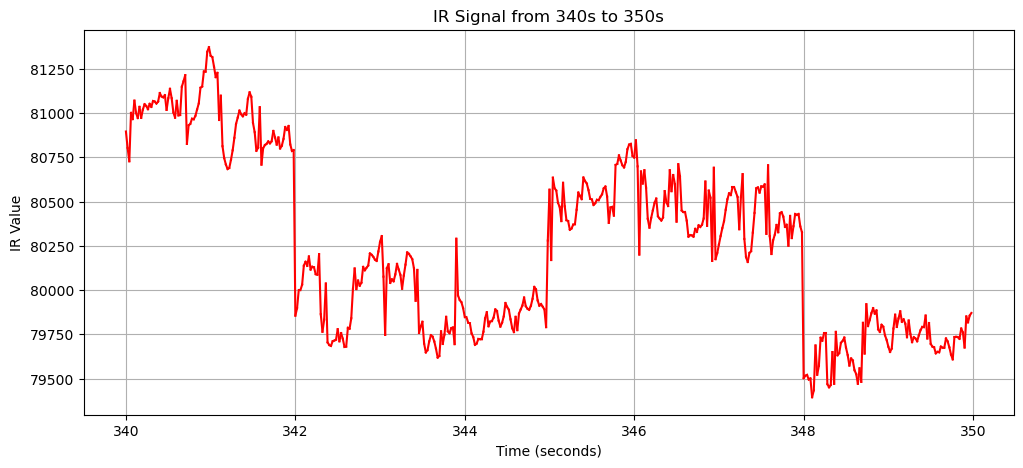

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pth = r'aos_data\merged_phuc_data.csv'
# Load the CSV file
df = pd.read_csv(pth)

# Sampling rate
fs = 50  # Hz
dt = 1 / fs  # Time step per sample

# Function to plot IR signal for a given time range
def plot_ir_signal(start_time=50, end_time=100):
    start_idx = int(start_time * fs)
    end_idx = int(end_time * fs)
    
    ir_values = df["IR"][start_idx:end_idx]
    labels = df["Label"][start_idx:end_idx]

    # Generate time axis
    time_axis = np.arange(start_time, end_time, dt)[:len(ir_values)]

    # Plot IR data
    plt.figure(figsize=(12, 5))
    for i in range(len(ir_values) - 1):
        color = "blue" if labels.iloc[i] == "awake" else "red"
        plt.plot(time_axis[i:i+2], ir_values.iloc[i:i+2], color=color)

    plt.xlabel("Time (seconds)")
    plt.ylabel("IR Value")
    plt.title(f"IR Signal from {start_time}s to {end_time}s")
    plt.grid()
    plt.show()

# Example usage: Adjust 'start_time' and 'end_time' as needed
plot_ir_signal(start_time=340, end_time=350)  # Adjust these values as needed


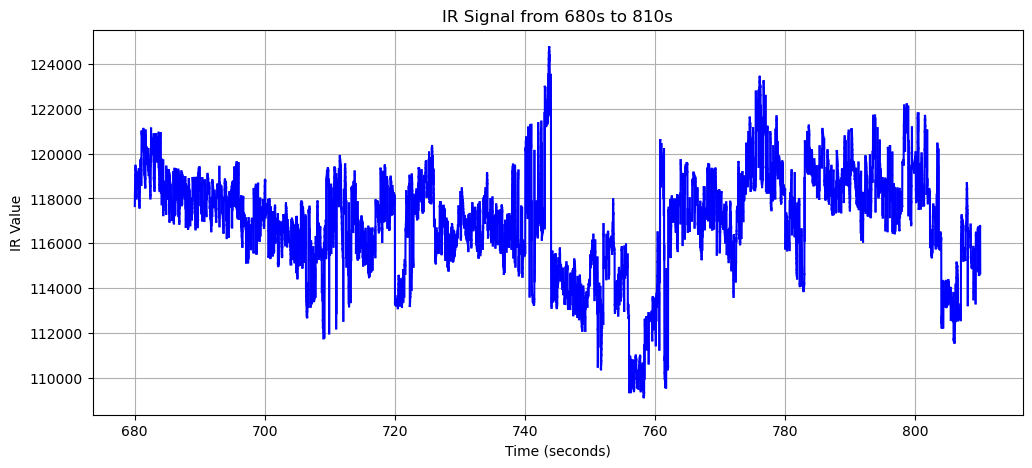

In [12]:
plot_ir_signal(start_time=680, end_time=810)  # Adjust these values as needed

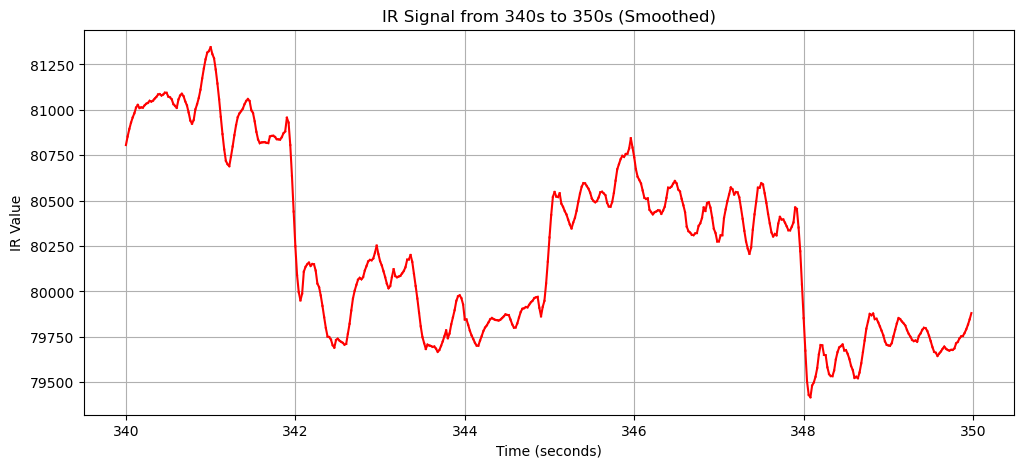

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter

pth = r'aos_data\merged_phuc_data.csv'
# Load the CSV file
df = pd.read_csv(pth)

# Sampling rate and time step
fs = 50  # Hz
dt = 1 / fs  # Time step per sample

# Function to plot IR signal for a given time range with optional smoothing
def plot_ir_signal(start_time=50, end_time=100, smooth=False):
    start_idx = int(start_time * fs)
    end_idx = int(end_time * fs)
    
    # Extract IR values and labels
    ir_values = df["IR"][start_idx:end_idx].values
    labels = df["Label"][start_idx:end_idx].values

    # Apply smoothing using a Savitzky-Golay filter if smooth=True
    if smooth:
        # Ensure window_length is odd and less than or equal to the length of the signal
        window_length = 11 if len(ir_values) >= 11 else (len(ir_values) // 2 * 2 + 1)
        ir_values = savgol_filter(ir_values, window_length=window_length, polyorder=2)
    
    # Generate time axis
    time_axis = np.arange(start_time, end_time, dt)[:len(ir_values)]

    # Plot IR data with color coding for 'awake' and 'sleep'
    plt.figure(figsize=(12, 5))
    for i in range(len(ir_values) - 1):
        color = "blue" if labels[i] == "awake" else "red"
        plt.plot(time_axis[i:i+2], ir_values[i:i+2], color=color)

    plt.xlabel("Time (seconds)")
    plt.ylabel("IR Value")
    plt.title(f"IR Signal from {start_time}s to {end_time}s {'(Smoothed)' if smooth else ''}")
    plt.grid()
    plt.show()

# Example usage: Plot the IR signal between 340s and 350s with smoothing applied
plot_ir_signal(start_time=340, end_time=350, smooth=True)


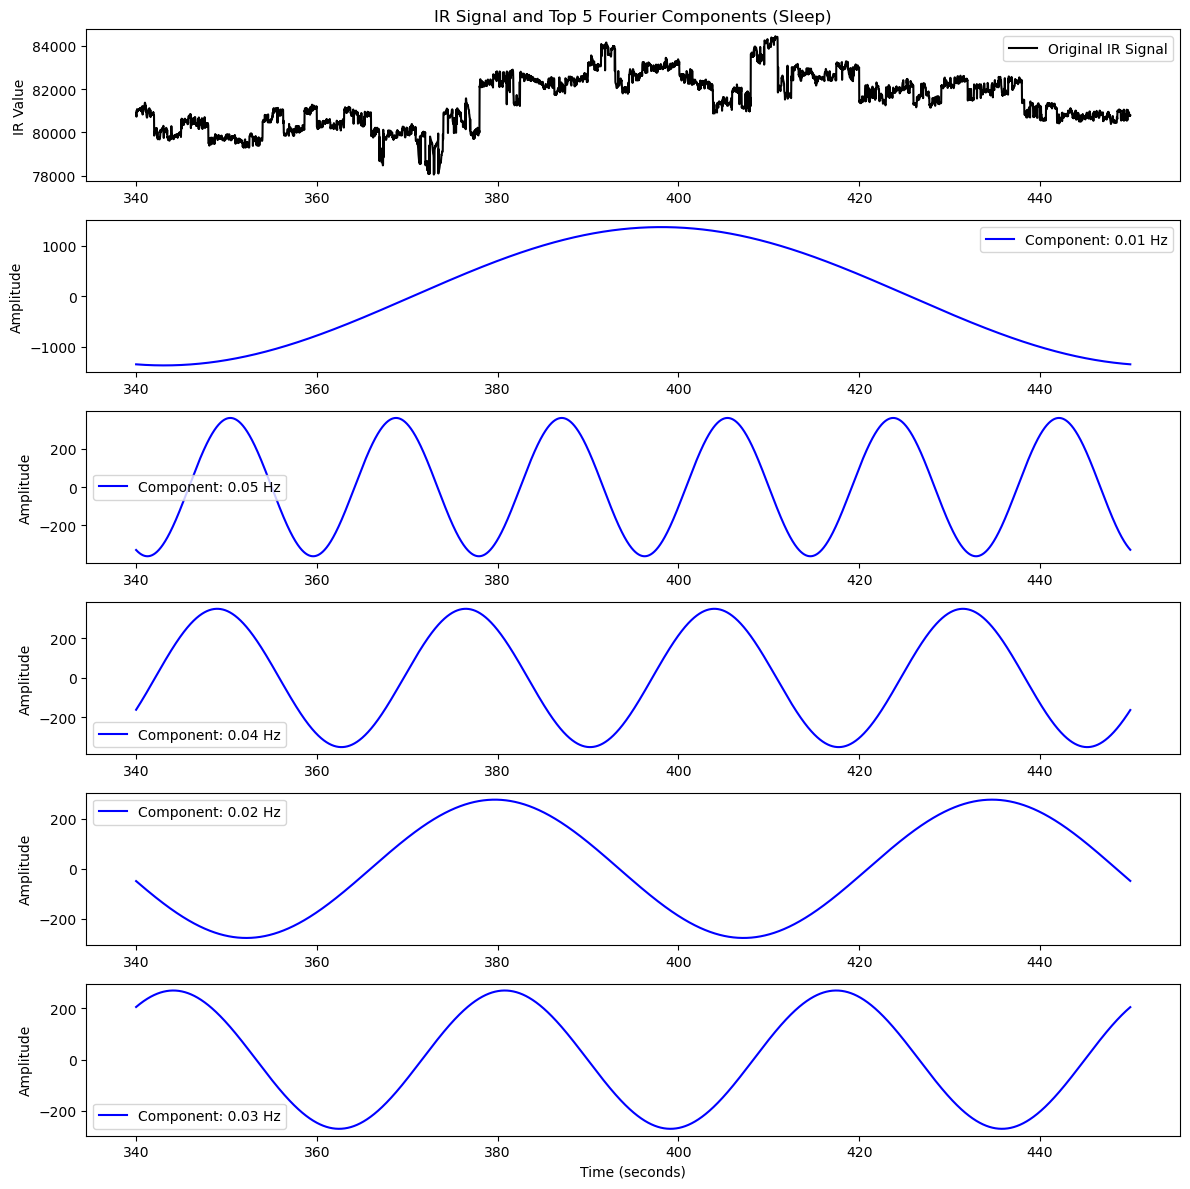

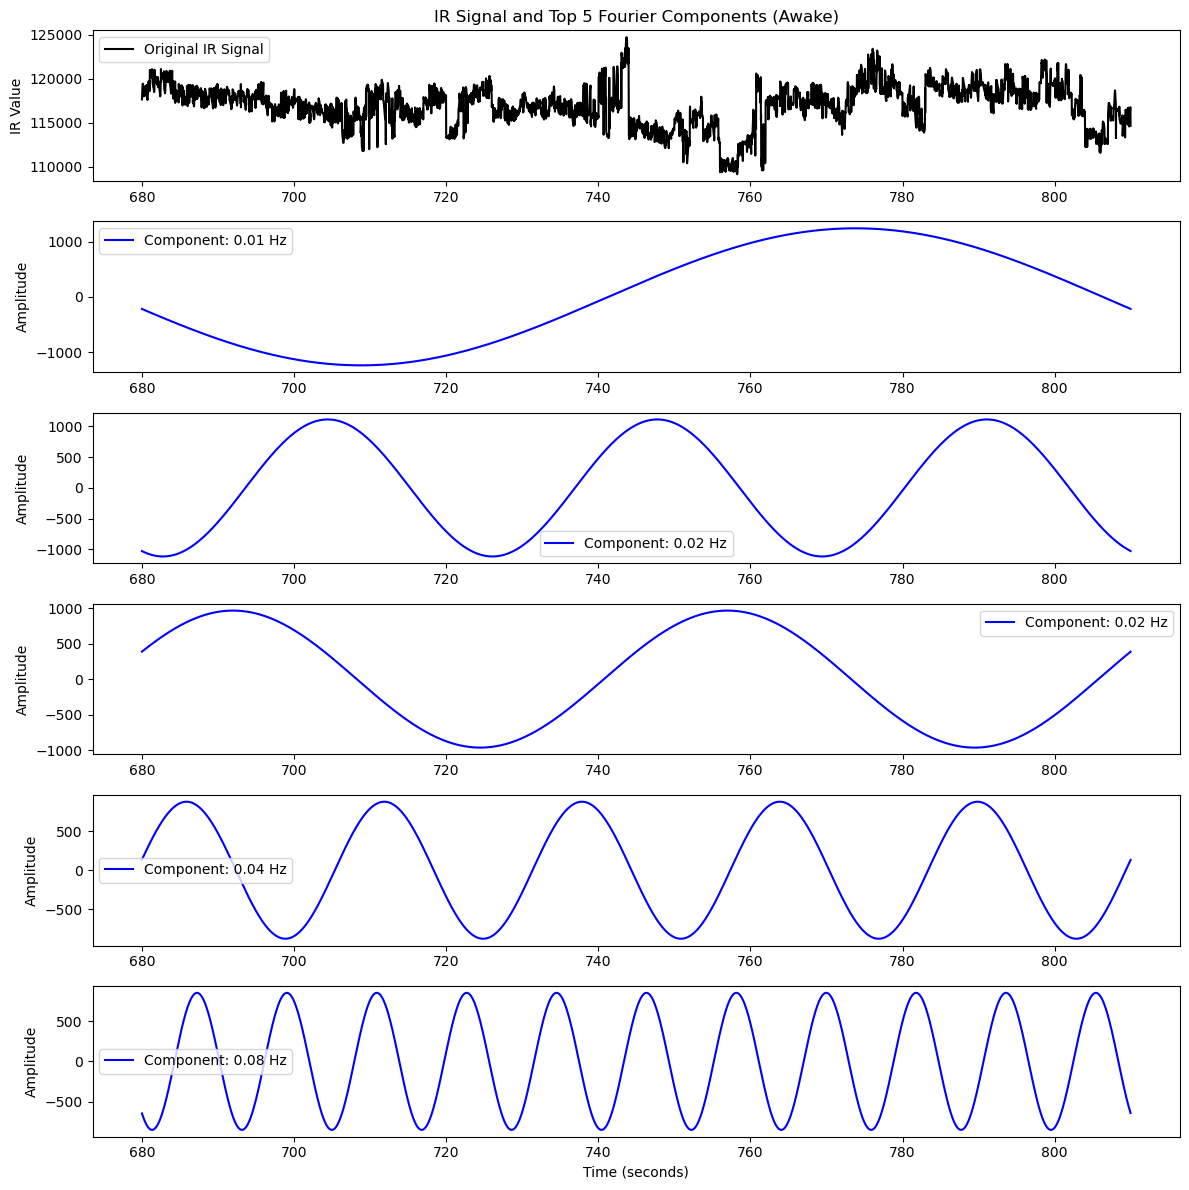

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft

pth = r'aos_data\merged_phuc_data.csv'
# Load the CSV file
df = pd.read_csv(pth)

# Sampling rate and time step
fs = 50  # Hz
dt = 1 / fs  # seconds per sample

def plot_fourier_components(start_time, end_time, state, num_components=5):
    # Convert times to sample indices
    start_idx = int(start_time * fs)
    end_idx = int(end_time * fs)
    
    # Extract the IR signal and generate time axis
    signal = df["IR"][start_idx:end_idx].values
    N = len(signal)
    t = np.arange(start_time, start_time + N * dt, dt)[:N]
    
    # Compute FFT
    fft_vals = fft(signal)
    freqs = np.fft.fftfreq(N, d=dt)
    
    # Only consider positive frequencies (ignore zero frequency)
    positive_indices = np.where(freqs > 0)[0]
    pos_freqs = freqs[positive_indices]
    pos_fft_vals = fft_vals[positive_indices]
    
    # Compute magnitudes and find the indices of the top components
    magnitudes = np.abs(pos_fft_vals)
    sorted_indices = np.argsort(magnitudes)[::-1]  # descending order
    top_indices = sorted_indices[:num_components]
    
    # Prepare figure: one subplot for original signal plus one for each component
    plt.figure(figsize=(12, (num_components+1)*2))
    
    # Plot the original IR signal
    ax = plt.subplot(num_components+1, 1, 1)
    ax.plot(t, signal, label="Original IR Signal", color="black")
    ax.set_title(f"IR Signal and Top {num_components} Fourier Components ({state})")
    ax.set_ylabel("IR Value")
    ax.legend()
    
    # Reconstruct signal from the top components (for illustration)
    reconstructed = np.zeros_like(signal, dtype=float)
    
    # Plot each Fourier component as a cosine wave
    for i, idx in enumerate(top_indices):
        freq = pos_freqs[idx]
        # For a real-valued signal, the amplitude is 2*|FFT|/N (for non-DC frequencies)
        amplitude = 2 * np.abs(pos_fft_vals[idx]) / N
        phase = np.angle(pos_fft_vals[idx])
        component = amplitude * np.cos(2 * np.pi * freq * t + phase)
        reconstructed += component
        
        ax_comp = plt.subplot(num_components+1, 1, i+2)
        ax_comp.plot(t, component, label=f'Component: {freq:.2f} Hz', color="blue")
        ax_comp.set_ylabel("Amplitude")
        ax_comp.legend()
    
    plt.xlabel("Time (seconds)")
    plt.tight_layout()
    plt.show()

# Analyze and plot for the sleep period (340s to 450s)
plot_fourier_components(start_time=340, end_time=450, state="Sleep", num_components=5)

# Analyze and plot for the awake period (680s to 810s)
plot_fourier_components(start_time=680, end_time=810, state="Awake", num_components=5)
